In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image

In [2]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
  
  return X


In [3]:
def Unet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  c1 = conv_block(input_img,n_filters,3,batch_norm)
  p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_block(p1,n_filters*2,3,batch_norm);
  p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_block(p2,n_filters*4,3,batch_norm);
  p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3,n_filters*8,3,batch_norm);
  p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv_block(p4,n_filters*16,3,batch_norm);

  u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  c6 = Dropout(dropout)(c6)
  u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);

  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  c7 = Dropout(dropout)(c7)
  u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);

  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);

  u9 = concatenate([u9,c1]);

  c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1, 1,1), activation='softmax')(c9)
  print("!!!!!!!!!!!!!!!!!!!")
  print(outputs.shape)
  model = Model(inputs=input_img, outputs=outputs)

  return model

In [4]:
def standardize(image):

  standardized_image = np.zeros(image.shape)

  #
  
      # iterate over the `z` dimension
  for z in range(image.shape[2]):
      # get a slice of the image 
      # at channel c and z-th dimension `z`
      image_slice = image[:,:,z]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice)
      
      # divide by the standard deviation (only if it is different from zero)
      if(np.std(centered)!=0):
          centered = centered/np.std(centered) 

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[:, :, z] = centered

  ### END CODE HERE ###

  return standardized_image

In [5]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

In [6]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [7]:
input_img = Input((128,128,128,4))
model = Unet_3d(input_img,8,0.1,True)
learning_rate = 0.001
epochs = 5000
decay_rate = 0.0000001
model.compile(optimizer=Adam(lr=learning_rate, decay = decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

!!!!!!!!!!!!!!!!!!!
(None, 128, 128, 128, 4)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 872         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 32          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 128 0           batch_normalization[0][0]        
__________________________________________

In [8]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
### Path of directory 
Path='/content/drive/My Drive/BrainTumourData'

In [10]:
### Image and Label path
Image_path=f"{Path}/imagesTr"
Label_path=f"{Path}/labelsTr"

In [ ]:
### Storing all file name into list for further manipulation
lis_image=os.listdir(Image_path)
lis_label=os.listdir(Label_path)

In [ ]:
### remvoing dot conatin file or hidden files in Image file 
def remove_dot_contain_file(lis_files):
  """
  lis_files is the paramter 
  ex: it could be lis_image and lis_label
  """
  for i in range(len(lis_files)):
    if lis_files[i][0]==".":
      lis_files.pop(i)


In [ ]:
# remove_dot_contain_file(lis_label)

In [ ]:
### Sorting both the list 
lis_label.sort()
lis_image.sort()

In [ ]:
lis_image.pop(0)

'._BRATS_028.nii.gz'

In [ ]:
### checking common between two list image and label
count=0
for i in range(len(lis_label)):
  if lis_image[i]==lis_label[i]:
    count+=1
count


1

In [11]:
path = '/content/drive/MyDrive/BrainTumourData/'
all_images = sorted(os.listdir(path + 'imagesTr/'))[7:-5]
all_masks = sorted(os.listdir(path + 'labelsTr/'))[1:]
image_data = np.zeros((240,240,155,4))
mask_data=np.zeros((240,240,155))

In [12]:
x = all_images[1]
image_path = path + 'labelTr/' + x

In [13]:
image_path

'/content/drive/MyDrive/BrainTumourData/labelTr/BRATS_002.nii.gz'

In [13]:
!nvidia-smi


Thu Nov 19 10:12:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    243MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from tqdm.notebook import tqdm

In [1]:
for epochs in tqdm(range(30)):
  for num in range(3,250):
# data preprocessing starts here
    x = all_images[num]
    #print(x)
    image_path = path + 'imagesTr/' + x;
    #images = os.listdir(image_path)
    #images.sort()
    img = nib.load(image_path);
    image_data = img.dataobj
    image_data = np.asarray(image_data)
    
    y = all_masks[num]
    #print(y)
    mask_path = path + 'labelsTr/' + y;
    #masks = os.listdir(masks_path)
    #masks.sort()
    msk = nib.load(mask_path);
    mask_data = msk.dataobj
    mask_data = np.asarray(mask_data)
    # print(image_path)
    # print(image_data.shape)
    # print(mask_path)
    # print(mask_data.shape)
    reshaped_data=image_data[56:184,80:208,13:141,:]
    reshaped_image_data2=mask_data[56:184,80:208,13:141]   
    reshaped_data=reshaped_data.reshape(1,128,128,128,4)
    reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
    reshaped_image_data2[reshaped_image_data2==4] = 3
    hello = reshaped_image_data2.flatten()
    #y_to = keras.utils.to_categorical(y_to,num_classes=2)
    #print(reshaped_image_data2.shape)
    #print(hello[hello==3].shape)
    # print("Number of classes",np.unique(hello))
    class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)
    # print(class_weights)

    reshaped_image_data2 = to_categorical(reshaped_image_data2, num_classes = 4)

    # print(reshaped_data.shape)
    # print(reshaped_image_data2.shape)
    # print(type(reshaped_data))

    
    model.fit(x=reshaped_data,y=reshaped_image_data2, epochs = 1)
    model.save('3d_model_100.h5')

model.save('3d_model_10.h5')
    

NameError: ignored

## Inference part 

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import keras
import nibabel as nib
from keras.models import Model, load_model

from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#from skimage.io import imread, imshow, concatenate_images
#from skimage.transform import resize

In [ ]:
avg_sens = [0,0,0,0]
avg_spec = [0,0,0,0]

In [ ]:
def standardize(image):

  standardized_image = np.zeros(image.shape)

  #
  
      # iterate over the `z` dimension
  for z in range(image.shape[2]):
      # get a slice of the image 
      # at channel c and z-th dimension `z`
      image_slice = image[:,:,z]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice)
      
      # divide by the standard deviation (only if it is different from zero)
      if(np.std(centered)!=0):
          centered = centered/np.std(centered) 

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[:, :, z] = centered

  ### END CODE HERE ###

  return standardized_image

In [ ]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.
    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.
    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[0,:,:,:,class_num]
    class_label = label[0,:,:,:,class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute true positives, false positives, 
    # true negatives, false negatives
    tp = np.sum((class_pred == 1) & (class_label == 1))
    tn = np.sum((class_pred == 0) & (class_label == 0))
    fp = np.sum((class_pred == 1) & (class_label == 0))
    fn = np.sum((class_pred == 0) & (class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity



In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Nothing',
                    'Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        avg_sens[i] += sens
        avg_spec[i] += spec
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    #return patch_metrics

In [ ]:
import os
model = load_model('3d_model_10.h5',custom_objects = {'dice_coef_loss' : dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
path = '/content/drive/MyDrive/BrainTumourData/'
all_images = sorted(os.listdir(path + 'imagesTr/'))[7:-5]
all_masks = sorted(os.listdir(path + 'labelsTr/'))[1:]
image_data = np.zeros((240,240,155,4))
mask_data=np.zeros((240,240,155))

In [ ]:

loss_list = []
accu_list = []
mean_loss = 0
mean_accu = 0
import nibabel as nib
for num in range(251,281):
    #print(epochs)
    print("Entering Image" , num)

# data preprocessing starts here
    x = all_images[num]
    #print(x)
    image_path = path + 'imagesTr/' + x;
    #images = os.listdir(image_path)
    #images.sort()
    img = nib.load(image_path);
    image_data = img.dataobj
    image_data = np.asarray(image_data)
    
    y = all_masks[num]
    #print(y)
    mask_path = path + 'labelsTr/' + y;
    #masks = os.listdir(masks_path)
    #masks.sort()
    msk = nib.load(mask_path);
    mask_data = msk.dataobj
    mask_data = np.asarray(mask_data)
    # print(image_path)
    # print(image_data.shape)
    # print(mask_path)
    # print(mask_data.shape)

    reshaped_data=image_data[56:184,75:203,13:141,:]
    reshaped_data=reshaped_data.reshape(1,128,128,128,4)
    reshaped_image_data2=mask_data[56:184,75:203,13:141]

    reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
    reshaped_image_data2[reshaped_image_data2==4] = 3
    
    reshaped_image_data2 = keras.utils.to_categorical(reshaped_image_data2, num_classes = 4)
    Y_hat = model.predict(x=reshaped_data)
    #print(Y_hat.shape)
    Y_hat = np.argmax(Y_hat,axis = -1)
    print(Y_hat.shape)
    Y_hat = keras.utils.to_categorical(Y_hat)
    #print(Y_hat.shape)
    print(reshaped_image_data2.shape)

    get_sens_spec_df(Y_hat,reshaped_image_data2)   


    #print(reshaped_data.shape)
    #print(reshaped_image_data2.shape)
    #print(type(reshaped_data))
    print("Processed Image" , num)
    scores = model.evaluate(x=reshaped_data,y=reshaped_image_data2)
    loss_list.append(scores[0])
    accu_list.append(scores[1])
    #print(scores[1])
    mean_loss += scores[0]
    mean_accu += scores[1]
    #print(scores[1])
print()
print("Mean Dice Loss" , mean_loss/30)
print("Mean Dice Coefficient(Accuracy)" , mean_accu/30)
print()
print("Mean Sensitivity for class 0" , avg_sens[0]/30)
print("Mean Specificity for class 0" , avg_spec[0]/30)
print()
print("Mean Sensitivity for class 1" , avg_sens[1]/30)
print("Mean Specificity for class 1" , avg_spec[1]/30)
print()
print("Mean Sensitivity for class 2" , avg_sens[2]/30)
print("Mean Specificity for class 2" , avg_spec[2]/30)
print()
print("Mean Sensitivity for class 3" , avg_sens[3]/30)
print("Mean Specificity for class 3" , avg_spec[3]/30)

Entering Image 251
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
Processed Image 251
1/1 [==============================] - 0s 153ms/step - loss: 0.2962 - dice_coef: 0.7038
Entering Image 252
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
Processed Image 252
1/1 [==============================] - 0s 112ms/step - loss: 0.3816 - dice_coef: 0.6184
Entering Image 253
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
Processed Image 253
1/1 [==============================] - 0s 111ms/step - loss: 0.2852 - dice_coef: 0.7148
Entering Image 254
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
Processed Image 254
1/1 [==============================] - 0s 110ms/step - loss: 0.1351 - dice_coef: 0.8649
Entering Image 255
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
Processed Image 255
1/1 [==============================] - 0s 109ms/step - loss: 0.1761 - dice_coef: 0.8239
Entering Image 256
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
Processed Image 256
1/1 [==============================] - 0s 110ms/step - loss: 0.6292 - dice_coef:

IndexError: ignored

(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
Y_hat shape - (1, 128, 128, 128)


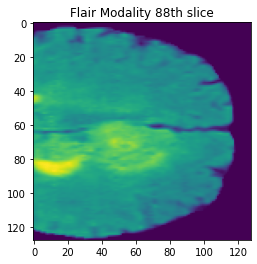

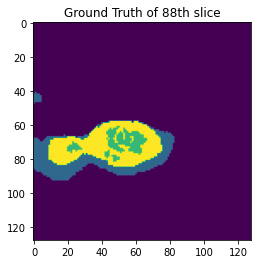

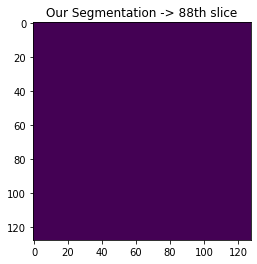

In [ ]:
x = all_images[289]
data = np.zeros((240,240,155,4))

image_path = path + 'imagesTr/' + x;
img = nib.load(image_path);
image_data = img.dataobj
image_data = np.asarray(image_data)

y = all_masks[289]
mask_path = path + 'labelsTr/' + y;
#masks = os.listdir(masks_path)
#masks.sort()
msk = nib.load(mask_path);
mask_data = msk.dataobj
mask_data = np.asarray(mask_data)

print(image_data.shape)
print(mask_data.shape)  

reshaped_data=image_data[56:184,75:203,13:141,:]
reshaped_data=reshaped_data.reshape(1,128,128,128,4)
reshaped_image_data2=mask_data[56:184,75:203,13:141]


reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
reshaped_image_data2[reshaped_image_data2==4] = 3
#hello = reshaped_image_data2.flatten()
#y_to = keras.utils.to_categorical(y_to,num_classes=2)
print(reshaped_image_data2.shape)
#print(hello[hello==3].shape)
#print("Number of classes",np.unique(hello))
#class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)
#print(class_weights)

#reshaped_image_data2 = keras.utils.to_categorical(reshaped_image_data2, num_classes = 4)

print(reshaped_data.shape)
print(reshaped_image_data2.shape)
print(type(reshaped_data))

Y_hat = model.predict(x=reshaped_data)
Y_hat = np.argmax(Y_hat,axis=-1)
print(f"Y_hat shape - {Y_hat.shape}")
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
img = reshaped_data[0,:,:,88,0]
imgplot = plt.imshow(img)
plt.title('Flair Modality 88th slice')
plt.savefig('Flair')
plt.show()

img2 = reshaped_image_data2[0,:,:,88]
imgplot2 = plt.imshow(img2)
plt.title('Ground Truth of 88th slice')
plt.savefig('Ground_Truth')
plt.show()

img3 = Y_hat[0,:,:,88]
imgplot3 = plt.imshow(img3)
plt.title('Our Segmentation -> 88th slice')
plt.savefig('Our Segmentation')
plt.show()